In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
try:
    # Try reading with the default engine and skipping bad lines
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WELFake_Dataset.csv', on_bad_lines='skip')
except Exception as e:
    print(f"Attempt 1 failed: {e}")
    try:
        # If the first attempt fails, try with the 'python' engine and skipping bad lines
        df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WELFake_Dataset.csv', engine='python', on_bad_lines='skip')
    except Exception as e2:
        print(f"Attempt 2 failed: {e2}")
        df = None # Ensure df is None if both attempts fail


# Display basic information about the dataset
if df is not None:
    print("=== DATASET OVERVIEW ===")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())

    print("\n=== DATASET INFORMATION ===")
    print(df.info())

    print("\n=== STATISTICAL SUMMARY ===")
    print(df.describe())

    print("\n=== MISSING VALUES ===")
    print(df.isnull().sum())

    print("\n=== LABEL DISTRIBUTION ===")
    print(df['label'].value_counts())
    print(f"Real news (1): {(df['label'] == 1).sum()} samples")
    print(f"Fake news (0): {(df['label'] == 0).sum()} samples")
else:
    print("\nFailed to load the dataset after multiple attempts.")

Attempt 1 failed: Error tokenizing data. C error: EOF inside string starting at row 27188
=== DATASET OVERVIEW ===
Dataset shape: (27207, 4)

First 5 rows:
  Unnamed: 0                                              title  \
0          0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1          1                                                NaN   
2          2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3          3  Bobby Jindal, raised Hindu, uses story of Chri...   
4          4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text label  
0  No comment is expected from Barack Obama Membe...     1  
1     Did they post their votes for Hillary already?     1  
2   Now, most of the demonstrators gathered last ...     1  
3  A dozen politically active pastors came here f...     0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...     1  

=== DATASET INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [5]:
# Data Preprocessing
print("=== DATA PREPROCESSING ===")

# Handle missing values
print("Handling missing values...")
# Fill missing title and text with empty strings instead of dropping rows
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

# Now drop rows where 'label' is missing
df = df.dropna(subset=['label'])

# Inspect unique values and their counts in the 'label' column after dropping NA labels
print("\n=== LABEL DISTRIBUTION AFTER DROPPING NA LABELS ===")
print(df['label'].value_counts())


# Convert label to numeric if necessary (assuming '0' and '1' are strings)
# Filter out rows where label is not '0' or '1')
df = df[df['label'].isin(['0', '1'])].copy()
df['label'] = df['label'].astype(int) # Convert '0' and '1' to integers

print("\n=== LABEL DISTRIBUTION AFTER CLEANING ===")
print(df['label'].value_counts())


# Combine title and text for better feature extraction
df['combined_text'] = df['title'] + ' ' + df['text']

print(f"\nDataset shape after cleaning: {df.shape}")

# Prepare features and target
X = df['combined_text']
y = df['label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

=== DATA PREPROCESSING ===
Handling missing values...

=== LABEL DISTRIBUTION AFTER DROPPING NA LABELS ===
label
1                                                  14114
0                                                  13071
 is just unbelievably rich from North Sea oil.         1
 за участие. Благодарю вас.                            1
Name: count, dtype: int64

=== LABEL DISTRIBUTION AFTER CLEANING ===
label
1    14114
0    13071
Name: count, dtype: int64

Dataset shape after cleaning: (27185, 5)
Features shape: (27185,)
Target shape: (27185,)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Text Vectorization using TF-IDF
print("=== TEXT VECTORIZATION ===")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Use top 5000 features
    stop_words='english',
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=5,
    max_df=0.7
)

X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TF-IDF features shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

=== TEXT VECTORIZATION ===
TF-IDF features shape: (27185, 5000)
Vocabulary size: 5000


In [8]:
# Split the data
print("=== DATA SPLITTING ===")

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training labels distribution:\n{y_train.value_counts()}")
print(f"Testing labels distribution:\n{y_test.value_counts()}")

=== DATA SPLITTING ===
Training set size: 21748
Testing set size: 5437
Training labels distribution:
label
1    11291
0    10457
Name: count, dtype: int64
Testing labels distribution:
label
1    2823
0    2614
Name: count, dtype: int64


In [9]:
# Decision Tree Model Training
print("=== DECISION TREE MODEL TRAINING ===")

# Initialize and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5
)

dt_classifier.fit(X_train, y_train)

print("Model training completed!")

=== DECISION TREE MODEL TRAINING ===
Model training completed!


In [10]:
# Model Evaluation
print("=== MODEL EVALUATION ===")

# Predictions
y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Fake News (0)', 'Real News (1)']))

=== MODEL EVALUATION ===
Accuracy: 0.9244 (92.44%)

=== CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

Fake News (0)       0.93      0.91      0.92      2614
Real News (1)       0.92      0.93      0.93      2823

     accuracy                           0.92      5437
    macro avg       0.92      0.92      0.92      5437
 weighted avg       0.92      0.92      0.92      5437



=== CONFUSION MATRIX ===


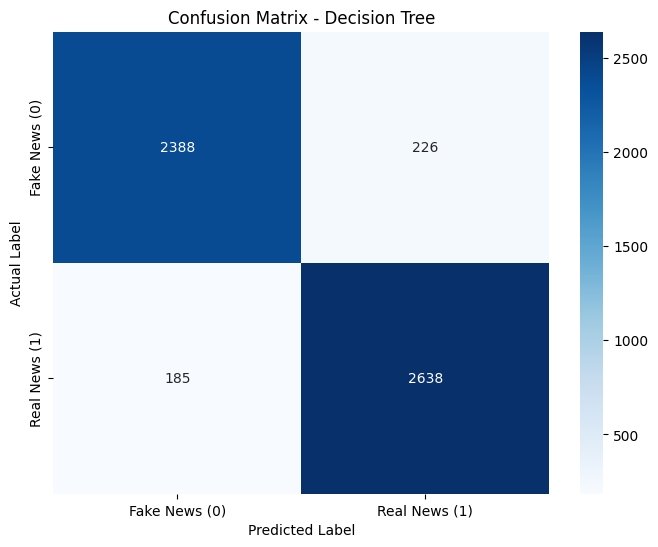

True Negatives (TN): 2388
False Positives (FP): 226
False Negatives (FN): 185
True Positives (TP): 2638


In [11]:
# Confusion Matrix
print("=== CONFUSION MATRIX ===")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake News (0)', 'Real News (1)'],
            yticklabels=['Fake News (0)', 'Real News (1)'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate performance metrics from confusion matrix
TN, FP, FN, TP = cm.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

In [12]:
# Performance Metrics Table
print("=== PERFORMANCE METRICS TABLE ===")

performance_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        f"{accuracy:.4f} ({accuracy*100:.2f}%)",
        f"{precision:.4f} ({precision*100:.2f}%)",
        f"{recall:.4f} ({recall*100:.2f}%)",
        f"{f1_score:.4f} ({f1_score*100:.2f}%)"
    ],
    'Description': [
        'Overall correctness of the model',
        'Ability to correctly identify real news',
        'Ability to find all real news',
        'Balance between precision and recall'
    ]
}

performance_df = pd.DataFrame(performance_metrics)
print(performance_df)

=== PERFORMANCE METRICS TABLE ===
      Metric            Score                              Description
0   Accuracy  0.9244 (92.44%)         Overall correctness of the model
1  Precision  0.9211 (92.11%)  Ability to correctly identify real news
2     Recall  0.9345 (93.45%)            Ability to find all real news
3   F1-Score  0.9277 (92.77%)     Balance between precision and recall


=== FEATURE IMPORTANCE ANALYSIS ===
Top 20 Most Important Features:
               feature  importance
3798           reuters    0.469037
4984        york times    0.179861
637          breitbart    0.080202
3897              said    0.029153
1825            follow    0.015893
2116           hillary    0.013357
1734    featured image    0.011297
4013               sen    0.010493
2220             image    0.006791
49                2016    0.005377
3392  president donald    0.004981
4776             video    0.004529
2990               new    0.004499
1053       contributed    0.004228
717         candidates    0.004202
3748       republicans    0.003884
4542          told cnn    0.003728
3212           patriot    0.003632
334               anti    0.003529
4437        tax reform    0.003445


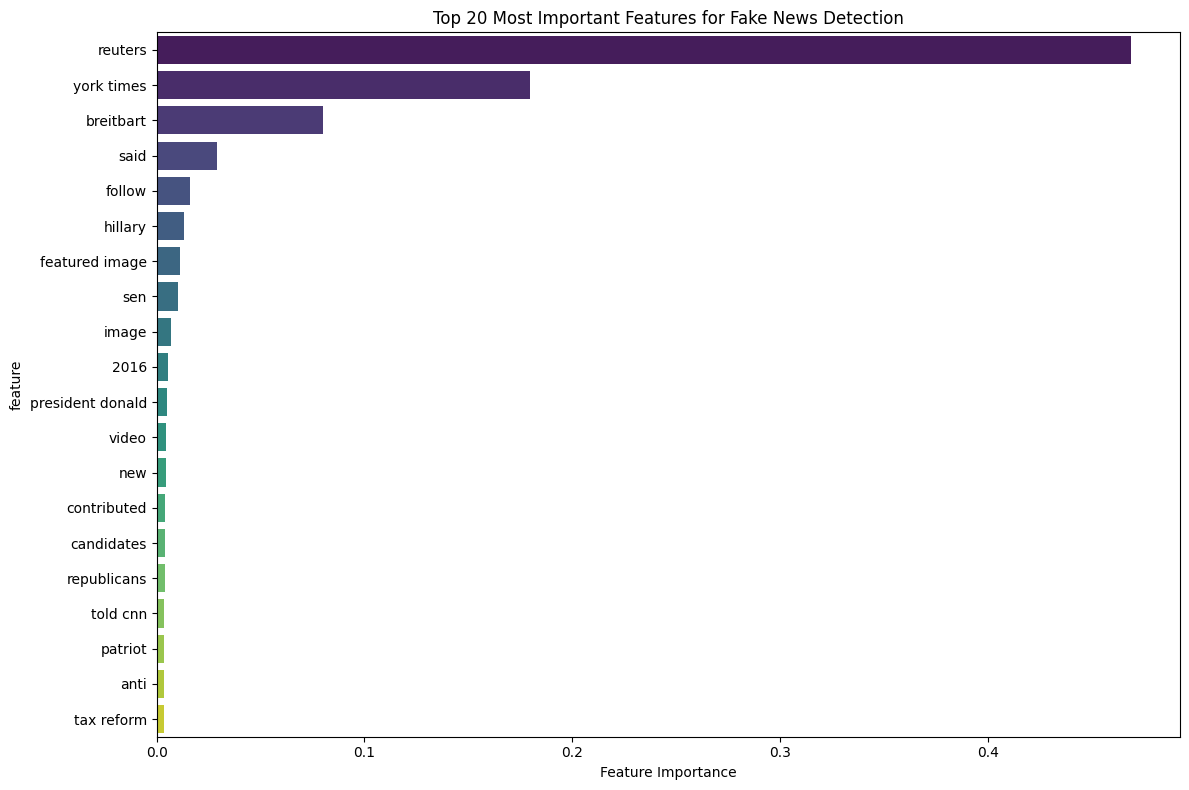

In [13]:
# Feature Importance Analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance
feature_importance = dt_classifier.feature_importances_

# Create a DataFrame for feature importance
feature_names = tfidf_vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort by importance and get top 20 features
top_features = importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_features)

# Plot top features
plt.figure(figsize=(12, 8))
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Most Important Features for Fake News Detection')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [14]:
# Model Performance Summary
print("=== MODEL PERFORMANCE SUMMARY ===")

print("📊 DECISION TREE FAKE NEWS DETECTION PERFORMANCE")
print("=" * 50)

print(f"\n🎯 OVERALL ACCURACY: {accuracy*100:.2f}%")

print(f"\n📈 DETAILED PERFORMANCE:")
print(f"   • Precision: {precision*100:.2f}%")
print(f"   • Recall: {recall*100:.2f}%")
print(f"   • F1-Score: {f1_score*100:.2f}%")

print(f"\n📊 CONFUSION MATRIX RESULTS:")
print(f"   • Correct Predictions: {TP + TN} ({(TP+TN)/len(y_test)*100:.2f}%)")
print(f"   • Incorrect Predictions: {FP + FN} ({(FP+FN)/len(y_test)*100:.2f}%)")
print(f"   • False Positives: {FP} (Real news misclassified as fake)")
print(f"   • False Negatives: {FN} (Fake news misclassified as real)")

print(f"\n📝 DATASET INFORMATION:")
print(f"   • Total Samples: {len(df)}")
print(f"   • Real News (1): {(df['label'] == 1).sum()}")
print(f"   • Fake News (0): {(df['label'] == 0).sum()}")
print(f"   • Training Samples: {X_train.shape[0]}")
print(f"   • Testing Samples: {X_test.shape[0]}")

print(f"\n⚙️ MODEL CONFIGURATION:")
print(f"   • Algorithm: Decision Tree Classifier")
print(f"   • Max Depth: 20")
print(f"   • Features Used: {X_tfidf.shape[1]}")
print(f"   • Random State: 42")

# Performance Rating
if accuracy >= 0.9:
    rating = "EXCELLENT 🎉"
elif accuracy >= 0.8:
    rating = "VERY GOOD 👍"
elif accuracy >= 0.7:
    rating = "GOOD ✅"
elif accuracy >= 0.6:
    rating = "FAIR ⚠️"
else:
    rating = "NEEDS IMPROVEMENT ❌"

print(f"\n🏆 PERFORMANCE RATING: {rating}")

=== MODEL PERFORMANCE SUMMARY ===
📊 DECISION TREE FAKE NEWS DETECTION PERFORMANCE

🎯 OVERALL ACCURACY: 92.44%

📈 DETAILED PERFORMANCE:
   • Precision: 92.11%
   • Recall: 93.45%
   • F1-Score: 92.77%

📊 CONFUSION MATRIX RESULTS:
   • Correct Predictions: 5026 (92.44%)
   • Incorrect Predictions: 411 (7.56%)
   • False Positives: 226 (Real news misclassified as fake)
   • False Negatives: 185 (Fake news misclassified as real)

📝 DATASET INFORMATION:
   • Total Samples: 27185
   • Real News (1): 14114
   • Fake News (0): 13071
   • Training Samples: 21748
   • Testing Samples: 5437

⚙️ MODEL CONFIGURATION:
   • Algorithm: Decision Tree Classifier
   • Max Depth: 20
   • Features Used: 5000
   • Random State: 42

🏆 PERFORMANCE RATING: EXCELLENT 🎉


In [15]:
# Test with Sample Predictions
print("=== SAMPLE PREDICTIONS ===")

# Get some sample texts for testing
sample_indices = np.random.choice(X_test.shape[0], 5, replace=False)

print("Sample Predictions from Test Set:")
print("=" * 80)

for i, idx in enumerate(sample_indices):
    actual_label = y_test.iloc[idx]
    predicted_label = y_pred[idx]
    confidence = max(y_pred_proba[idx])

    # Get the original text (first 100 characters)
    sample_text = df.iloc[X_test.indices[idx]]['combined_text'][:100] + "..."

    status = "✅ CORRECT" if actual_label == predicted_label else "❌ WRONG"

    print(f"\nSample {i+1}:")
    print(f"Text: {sample_text}")
    print(f"Actual: {'Real News (1)' if actual_label == 1 else 'Fake News (0)'}")
    print(f"Predicted: {'Real News (1)' if predicted_label == 1 else 'Fake News (0)'}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Status: {status}")

=== SAMPLE PREDICTIONS ===
Sample Predictions from Test Set:

Sample 1:
Text: Zimbabwe's ruling party says will never succumb to army threats HARARE (Reuters) - Zimbabwe s ruling...
Actual: Real News (1)
Predicted: Real News (1)
Confidence: 1.0000
Status: ✅ CORRECT

Sample 2:
Text: LIKE A BOSS! President Trump’s Arrival at the EU Headquarters: “You can expect the president to be v...
Actual: Fake News (0)
Predicted: Fake News (0)
Confidence: 0.9931
Status: ✅ CORRECT

Sample 3:
Text: Crack in Earth’s magnetic shield detected Crack in Earth’s magnetic shield detected 11/04/2016 
DNA ...
Actual: Fake News (0)
Predicted: Fake News (0)
Confidence: 0.9931
Status: ✅ CORRECT

Sample 4:
Text:  Hillary’s Latest Challenge To Progressives Is One That Needs To Be Taken Very Seriously (VIDEO) App...
Actual: Real News (1)
Predicted: Real News (1)
Confidence: 1.0000
Status: ✅ CORRECT

Sample 5:
Text: WOW! VIDEO SURFACES OF BERNIE SANDERS Praising Communism And Bread Lines [Video] Please share this e..